In [1]:
from argparse import ArgumentParser
from cpo import CPO
from memory import Memory
from models import build_diag_gauss_policy, build_mlp
# from simulators import SinglePathSimulator
from torch_utils.torch_utils import get_device
import pandas as pd
import numpy as np

from data_util import read_file
# from fair_env_simulator import *
from fair_env import *
import torch
import os
import time
import torch.nn.functional as F

In [2]:
model_name = 'fairrec'
data_name = 'ml-20m'
data = read_file('../data/'+data_name+'/train_data.csv')
item_embeddings = np.load('../data/'+data_name+'/item_embed.npy')
user_embeddings = np.load('../data/'+data_name+'/user_embed.npy')
item_indicator = np.load('../data/'+data_name+'/item_cost_indicator_28.npy')

nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]
print('num of users: %d, num of items: %d' %(nb_user, nb_item))

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

env_args = {}
env_args['data'] = data
env_args['nb_user'] = nb_user
env_args['nb_item'] = nb_item
env_args['item_embeddings'] = item_embeddings
env_args['user_embeddings'] = user_embeddings
env_args['item_indicator'] = item_indicator
env_args['device'] = device
env_args['gamma'] = 0.95
env_args['frac'] = 0.05

env = Environment(**env_args)
print('Successfully create Training Env!')

num of users: 138493, num of items: 15451
Successfully create Training Env!


In [3]:
history_length = 5 # N in article
ra_length = 1 # K in article
state_space_size = item_embeddings.shape[1] * history_length
action_space_size = item_embeddings.shape[1] * ra_length


vf_hidden_dims = [64]
vf_args = (state_space_size + 1, vf_hidden_dims, 1)
value_fun = build_mlp(*vf_args)

cost_fun = build_mlp(*vf_args)

policy_hidden_dims = [64]
policy_args = (state_space_size, policy_hidden_dims, action_space_size)
policy = build_diag_gauss_policy(*policy_args)


policy.to(device)
value_fun.to(device)
cost_fun.to(device)
print(policy)
print(value_fun)
print(cost_fun)

Sequential(
  (0): Linear(in_features=500, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=100, bias=True)
  (3): DiagGaussianLayer()
)
Sequential(
  (0): Linear(in_features=501, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=501, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=1, bias=True)
)


In [4]:
from collections import defaultdict, namedtuple
import numpy as np
import torch

from autoassign import autoassign
from memory import Memory, Trajectory
from torch_utils.torch_utils import get_device
from gini import gini


class Simulator:
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        self.env = env
        self.policy = policy


class SinglePathSimulator(Simulator):
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        Simulator.__init__(self, env, policy, n_trajectories, trajectory_len, **env_args)
        self.item_embeddings= env_args['item_embeddings']
        self.trajectory_len = trajectory_len
        self.n_trajectories = n_trajectories
        self.nb_item = env_args['nb_item']
        self.device = env_args['device']
        self.hit_rate = []
        self.gini_coefficient = []
        self.pop_rate = []

    def run_sim(self):
        self.policy.eval()
        
        
        with torch.no_grad():
            trajectories = np.asarray([Trajectory() for i in range(self.n_trajectories)])

            ra_length = 1
#             epsilon = 0.9
            item_embeds = torch.from_numpy(self.item_embeddings).to(self.device).float()

            ave_score = 0
            ave_cost = 0
            states = self.env.reset()
#             print(states.shape)
            recommended_item_onehot = torch.FloatTensor(self.n_trajectories, self.nb_item).zero_().to(device)
            recommendations = []
            for t in range(self.trajectory_len): 
                policy_input = torch.FloatTensor(states).to(self.device).view(self.n_trajectories, -1)
                weight_dists = self.policy(policy_input)
                w = weight_dists.sample()
#                 print(w.shape)
                item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(self.n_trajectories, ra_length, -1)
                item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
                item_idxes = torch.argmax(item_weights,dim=2)

                recommendations.append(item_idxes)
                recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)

                actions = item_embeds[item_idxes.cpu().detach()]
                states_prime, rewards, costs, info = self.env.step(actions, item_idxes)

                for i in range(len(trajectories)):
                    trajectory = trajectories[i]
                    trajectory.observations.append(policy_input[i].to(device).squeeze())
                    trajectory.actions.append(actions[i].to(device).squeeze())
                    trajectory.rewards.append(rewards[i].to(device).squeeze())
                    trajectory.costs.append(costs[i].to(device).squeeze())


                states = states_prime
                ave_score += torch.sum(info).detach().cpu()
                ave_cost += torch.sum(costs).detach().cpu()
                 
            memory = Memory(trajectories)
    
#             print(ave_score.float()/(self.trajectory_len*self.n_trajectories), ave_cost/(self.trajectory_len*self.n_trajectories))
            self.pop_rate.append(ave_cost/(self.trajectory_len*self.n_trajectories))

            recommendation_tensor = torch.cat(recommendations,1)
            idx, val = torch.unique(torch.cat(recommendations), return_counts=True)
            hr = (ave_score.float()/(self.trajectory_len*self.n_trajectories)).cpu().numpy()
            self.hit_rate.append(hr)
            
            val_ = torch.cat((val.float(),torch.zeros(nb_item-len(val)).to(device)))
            g = gini(val_.cpu().numpy())
            self.gini_coefficient.append(g)
            
#             print('hit rate: %f, gini: %f' %(hr, g))
#             print(recommendation_tensor)
            return memory

In [5]:
n_trajectories = env.nb_user
trajectory_len = 10
simulator = SinglePathSimulator(env, policy, n_trajectories, trajectory_len, **env_args)

max_constraint_val = 100
cpo = CPO(policy, value_fun, cost_fun, simulator, device, model_name=model_name, max_constraint_val=max_constraint_val, continue_from_file=False)
n_episodes = 100
cpo.train(n_episodes)

Step Len.: 0.9
[Episode]: 1 | [Avg. Reward]: 0.1458483785390854 | [Avg. Cost]: 3.52707576751709 | [Elapsed Time]: 0:00:26
Step Len.: 0.9
[Episode]: 2 | [Avg. Reward]: 0.13588447868824005 | [Avg. Cost]: 3.597400665283203 | [Elapsed Time]: 0:00:58
Step Len.: 0.9
[Episode]: 3 | [Avg. Reward]: 0.14223827421665192 | [Avg. Cost]: 3.6151623725891113 | [Elapsed Time]: 0:01:30
Step Len.: 0.9
[Episode]: 4 | [Avg. Reward]: 0.15523464977741241 | [Avg. Cost]: 3.625415086746216 | [Elapsed Time]: 0:02:03
Step Len.: 0.9
[Episode]: 5 | [Avg. Reward]: 0.1561010777950287 | [Avg. Cost]: 3.6986281871795654 | [Elapsed Time]: 0:02:35
Step Len.: 0.9
[Episode]: 6 | [Avg. Reward]: 0.15277978777885437 | [Avg. Cost]: 3.7503249645233154 | [Elapsed Time]: 0:03:08
Step Len.: 0.9
[Episode]: 7 | [Avg. Reward]: 0.15812274813652039 | [Avg. Cost]: 3.824693202972412 | [Elapsed Time]: 0:03:41
Step Len.: 0.9
[Episode]: 8 | [Avg. Reward]: 0.15812274813652039 | [Avg. Cost]: 3.8259928226470947 | [Elapsed Time]: 0:04:13
Step Le

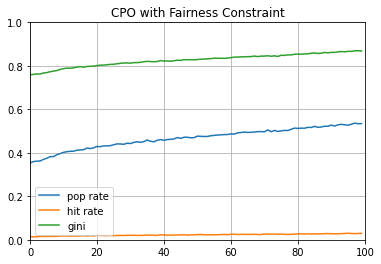

In [6]:
import matplotlib.pyplot as plt
hr = np.vstack(simulator.hit_rate)
pr = torch.stack(simulator.pop_rate)
gn = simulator.gini_coefficient

plt.plot(pr, label='pop rate')
plt.plot(hr, label='hit rate')
plt.plot(gn, label='gini')
plt.ylim(0, 1)
plt.xlim(0,100)
plt.legend()
plt.grid()
plt.title('CPO with Fairness Constraint')
plt.savefig('../fig/cpo_train_'+data_name+'.png')
plt.show()

In [9]:
# from env import *
from fair_env import *
# from tqdm import tqdm

with torch.no_grad():  
    test_data = read_file('../data/'+data_name+'/test_data.csv')
    test_env_args = {}
    test_env_args['data'] = test_data
    test_env_args['nb_user'] = nb_user
    test_env_args['nb_item'] = nb_item
    test_env_args['item_embeddings'] = item_embeddings
    test_env_args['user_embeddings'] = user_embeddings
    test_env_args['item_indicator'] = item_indicator
    test_env_args['device'] = device
    test_env_args['gamma'] = 0.95
    test_env_args['frac'] = 0.05
    
    test_trajectory_len = 100
    test_env = Environment(**test_env_args)
    states = test_env.reset()
    item_embeds = torch.from_numpy(item_embeddings).to(device).float()
    
    num_click = 0
    num_cost = 0
    test_res = []
    recommendations = []
    recommended_item_onehot = torch.FloatTensor(test_env.nb_user, test_env.nb_item).zero_().to(device)  
    test_gini_coefficient = []
    test_pop_rate = []
    for t in range(test_trajectory_len):
        policy_input = torch.FloatTensor(states).to(device).view(test_env.nb_user, -1)
        weight_dists = policy(policy_input)
        w = weight_dists.sample()
        item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(test_env.nb_user, ra_length, -1)
        item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
        item_idxes = torch.argmax(item_weights,dim=2)
        actions = item_embeds[item_idxes.cpu().detach()]
        recommendations.append(item_idxes)
        recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)
        states_prime, rewards, costs, test_info = test_env.step(actions, item_idxes)
        states = states_prime

        num_click += torch.sum(test_info)
        num_cost += torch.sum(costs).detach().cpu()
        test_pop_rate.append(num_cost/((t+1)*states.shape[0]))
        idx, val = torch.unique(torch.stack(recommendations), return_counts=True)
        if t == 0:
            test_res.append(test_info.squeeze())
        else:
            test_res.append(test_res[-1] + test_info.squeeze())
       
        val_ = torch.cat((val.float(),torch.zeros(nb_item-len(val)).to(device)))
        g = gini(val_.cpu().numpy())
        test_gini_coefficient.append(g)

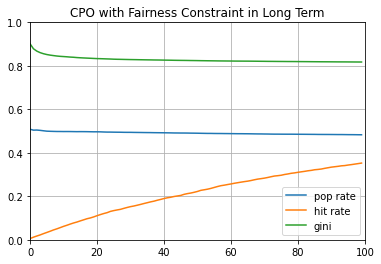

In [11]:
import matplotlib.pyplot as plt

test_res_ = torch.stack(test_res).transpose(0,1)
hr = []
for i in range(test_trajectory_len):
    hits = torch.sum(test_res_[:,i] > 0)
    hr.append(hits.detach().cpu().numpy()/test_env.nb_user)
    
pr = torch.stack(test_pop_rate)
gn = test_gini_coefficient

plt.plot(pr, label='pop rate')
plt.plot(hr, label='hit rate')
plt.plot(gn, label='gini')
plt.ylim(0, 1)
plt.xlim(0,100)
plt.legend()
plt.grid()
plt.title('CPO with Fairness Constraint in Long Term')
plt.savefig('./fig/cpo_test_'+data_name+'.png')
plt.show()